In [ ]:
!kaggle competitions download -c kuzushiji-recognition -p raw

!unzip -n -q raw/train.csv.zip -d data
!chmod 444 data/train.csv 
!unzip -n -q raw/train_images.zip -d data/train_images
!unzip -n -q raw/test_images.zip -d data/test_images

!cp -f raw/unicode_translation.csv data/

In [ ]:
!pip install wget
!wget -nd -q --show-progress https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip -P raw
!unzip -n -q raw/NotoSansCJKjp-hinted.zip -d assets

In [1]:
import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.font_manager as font_manager
import cv2

import re
import csv
from tqdm import tqdm_notebook as tqdm

In [2]:
input_dir = 'data'

font_path = 'assets/NotoSansCJKjp-Regular.otf'
prop = font_manager.FontProperties(fname=font_path)

In [3]:
df = pd.read_csv(input_dir + '/train.csv')
df['chars'] = df.labels.str.findall(r"[\w\+]{6}[\s\d]*\d")
df.head()

,image_id,labels,chars
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...,"[U+306F 1231 3465 133 53, U+304C 275 1652 84 6..."
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...,"[U+306F 1087 2018 103 65, U+304B 1456 1832 40 ..."
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...,"[U+306F 572 1376 125 57, U+306E 1551 2080 69 6..."
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...,"[U+3082 1455 3009 65 44, U+516B 1654 1528 141 ..."
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...,"[U+309D 1201 2949 27 33, U+309D 1196 1539 27 3..."


In [31]:
with open('data/unicode_translation.csv') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    unicode = dict(reader)

In [108]:
def id_to_path(input_id, dir_type='train'):
    path = input_dir + '/' + dir_type + '_images/' + input_id
    if '.jpg' not in path:
        path = path + '.jpg'
        
    return path

def label_explode(l):
    codename, x, y, w, h = str.split(l)
    char = unicode[codename]
    x, y, w, h = int(x), int(y), int(w), int(h)
    
    return char, codename, x, y, w, h

def page_to_bw(*args, **kwargs):
    path = id_to_path(*args, **kwargs)    
    
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    (thresh, img_bw) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_bw = cv2.bitwise_not(img_bw)
    
    return img_bw

def print_labels(ax, labels, im_id):
    img_bw = page_to_bw(im_id)
    ax.imshow(img_bw, cmap='gray')
    
    for l in labels:
        char, uc, x, y, w, h = label_explode(l)
        rect = Rectangle((x, y), w, h, linewidth=1, edgecolor="g", facecolor="none")
        ax.add_patch(rect)

        x_text = x + w + 10
        y_text = y + (h/2)
        ax.text(x_text, y_text, char, fontproperties=prop, color='g', size=24)
    
    return img_bw

def find_label(l, img):
    char, uc, x, y, w, h = label_explode(l)
    limg = img[y:y+h, x:x+w]
    
    return limg

def make_square(img, dim=(64, 64)):
    aspect = img.shape
    max_aspect = max(aspect)
    
    if max_aspect % 2 != 0:
        max_aspect += 11
    else:
        max_aspect += 10
        
    y_growth = (max_aspect - aspect[0])/2
    x_growth = max_aspect - aspect[1]
    
    t, b, l, r = int(np.floor(y_growth/2)), int(np.ceil(y_growth/2)), int(np.floor(x_growth/2)), int(np.ceil(x_growth/2))
    
    square_img = cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=(0,0,0))
    square_img = cv2.resize(square_img, dim)
    
    return square_img

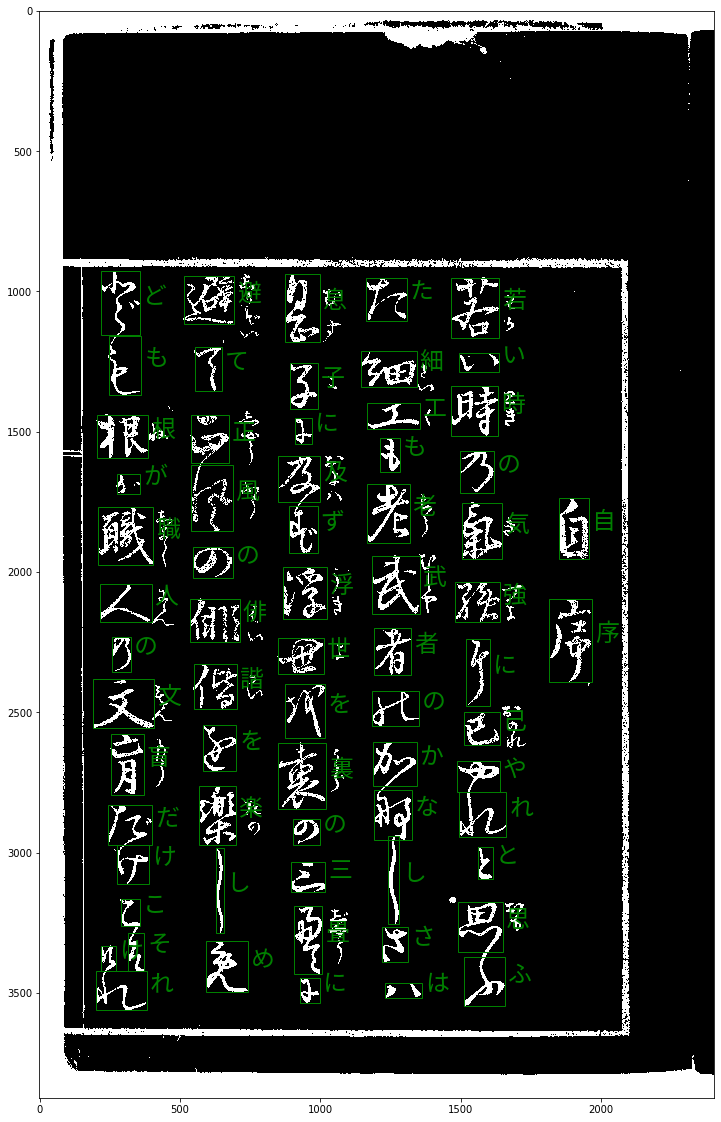

In [107]:
row = df.loc[df.image_id == '100241706_00004_2']
test_id = row['image_id'].values[0]
test_labels = row['chars'].values[0]

fig, ax = plt.subplots(figsize=(20,20))
img_bw = print_labels(ax, test_labels, test_id)

In [110]:
dfe = df[['image_id','chars']].explode('chars').reset_index()
dfd = pd.DataFrame(df_test['chars'].str.split(expand=True).values, columns=('unicode', 'x', 'y', 'width', 'height'))

dfo = pd.concat([dfe,dfd], axis=1).loc[:500, :]
nums = ['x','y','width','height']
for n in nums:
    dfo[n] = pd.to_numeric(dfo[n], errors='coerce', downcast='integer')

dfo.drop(['index'], axis=1, inplace=True)

def store_image(row):
    page = page_to_bw(row['image_id'])
    
    y_min = int(row.y)
    y_max = int(y_min + row.height)
    x_min = int(row.x)
    x_max = int(x_min + row.width)
    
    img = page[y_min:y_max, x_min:x_max]
    simg = make_square(img)
    
    return simg

dfo['img'] = dfo.apply(lambda x: store_image(x), axis=1)

In [120]:
dfe.shape

(683740, 3)

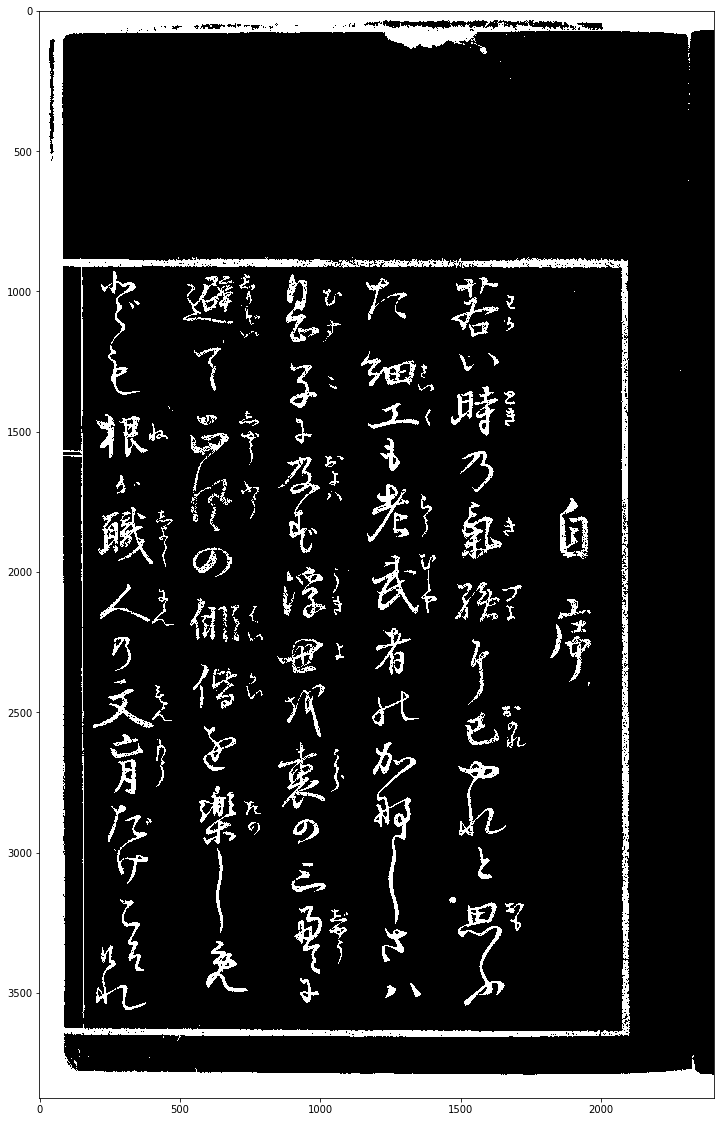

In [115]:
fig = plt.figure(figsize=(20,20))
plt.imshow(page_to_bw('100241706_00004_2'), cmap='gray')

(64, 64)
(64, 64)
(64, 64)
(64, 64)


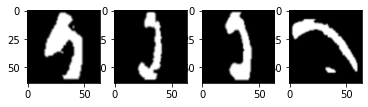

In [7]:
fig, axes = plt.subplots(1, 4)
for l, a in zip(test_labels[:4], axes):
    limg = find_label(l, img_bw)
    simg = make_square(limg)
    a.imshow(simg, cmap='gray', interpolation='bicubic')
    print(simg.shape)
    
plt.show()

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=100))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model, iterating on the data in batches of 32 samples
model.fit(data, labels, epochs=10, batch_size=32)